## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score

In [4]:
# compute the gini index from the given labels
def gini(sequence):
    # count the appearance of label 1
    cnt = 0
    for i in range(len(sequence)):
        if sequence[i] == 1: cnt += 1
    p1 = cnt / len(sequence) # probability of label 1
    p2 = 1 - p1 # probability of the other label
    n = 1 - p1 ** 2 - p2 ** 2
    return n

# compute the entropy from the given labels
def entropy(sequence):
    # count the appearance of label 1
    cnt = 0
    for i in range(len(sequence)):
        if sequence[i] == 1: cnt += 1
    p1 = cnt / len(sequence) # probability of label 1
    p2 = 1 - p1 # probability of the other label
    # handle the case of getting a list having the same label
    # to prevent processing zero values in p1 & p2
    if not p1 or not p2: return 0
    else:
        n = - (p1 * np.log2(p1)) - (p2 * np.log2(p2))
        return n

In [5]:
# 1 = class 1, 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [6]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [7]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [8]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

x_train = train_df.drop('price_range', axis=1)
y_train = train_df.loc[:, "price_range"]
x_val = val_df.drop('price_range', axis=1)
y_val = val_df.loc[:, "price_range"]

print(train_df.shape)
print(val_df.shape)

val_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1883,1,2.7,1,6,1,30,0.5,95,2,...,531,791,3724,16,15,20,1,1,1,1
1,987,1,1.9,0,4,1,52,0.5,83,3,...,419,736,2757,17,12,15,1,1,0,1
2,1306,1,2.1,1,2,1,33,0.4,174,3,...,867,1258,2521,6,5,16,1,0,0,1
3,1611,1,0.5,1,11,0,3,0.6,98,3,...,303,714,1595,8,4,9,1,0,1,0
4,862,1,0.8,1,3,0,23,0.4,165,2,...,793,1758,278,16,3,11,0,0,1,0


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and train the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [9]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        # store the criterion and max_depth for future usage
        self.criterion = criterion
        self.max_depth = max_depth

    # split the dataset based on an attribute's value
    # return the left and right child
    def try_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] <= value: left.append(row)
            else: right.append(row)
        return left, right

    # random sample attributes' index for random forest
    def sample_features(self, dataset, max_features):
        sample_index = np.random.choice(len(dataset[0]) - 1, max_features, replace=False)
        return sample_index

    # select the best split
    def select_split(self, dataset):
        # select the best split from the random sampled features for random forest
        if self.random_forest == True:
            # setup initial values for a node:
            #   index: the attribute's index
            #   value: the threshold used to split
            #   score: purity after spliting (weighted average gini-index or entropy)
            #   left & right: left & right child
            tmp_index, tmp_value, tmp_score, tmp_left, tmp_right = 999, 9999, 999, None, None
            sample_index = self.sample_features(dataset, max_features=self.max_features)
            for i in sample_index: # iterate from random sampled index
                thresholds = set([row[i] for row in dataset]) # pick out unique values for the certain attribute
                for t in thresholds:
                    if t == max(thresholds): continue
                    left, right = self.try_split(i, t, dataset)
                    left_labels = [row[-1] for row in left]
                    right_labels = [row[-1] for row in right]
                    if self.criterion == 'gini':
                        score = (gini(left_labels) * len(left) + gini(right_labels) * len(right)) / (len(left) + len(right))
                    else: score = (entropy(left_labels) * len(left) + entropy(right_labels) * len(right)) / (len(left) + len(right))
                    # find the split that yields the lowest value of gini or entropy
                    if score < tmp_score: # score stores the minimum score in the end
                        tmp_index, tmp_value, tmp_score, tmp_left, tmp_right = i, t, score, left, right
            return {'index':tmp_index, 'value':tmp_value, 'left':tmp_left, 'right':tmp_right}
        else:
            tmp_index, tmp_value, tmp_score, tmp_left, tmp_right = 999, 9999, 999, None, None
            for i in range(len(dataset[0]) - 1): # iterate from all index
                thresholds = set([row[i] for row in dataset]) # pick out unique values for the certain attribute
                for t in thresholds:
                    if t == max(thresholds): continue
                    left, right = self.try_split(i, t, dataset)
                    left_labels = [row[-1] for row in left]
                    right_labels = [row[-1] for row in right]
                    if self.criterion == 'gini':
                        score = (gini(left_labels) * len(left) + gini(right_labels) * len(right)) / (len(left) + len(right))
                    else: score = (entropy(left_labels) * len(left) + entropy(right_labels) * len(right)) / (len(left) + len(right))
                    # find the split that yields the lowest value of gini or entropy
                    if score < tmp_score: # score stores the minimum score in the end
                        tmp_index, tmp_value, tmp_score, tmp_left, tmp_right = i, t, score, left, right
            return {'index':tmp_index, 'value':tmp_value, 'left':tmp_left, 'right':tmp_right}

    # create a leaf node
    def leaf(self, list):
        labels = [row[-1] for row in list]
        return max(labels, key=labels.count)

    # recursively split the tree and create leaf nodes
    def split(self, node, depth):
        left, right = node['left'], node['right']

        # one side is empty after split
        if not left or not right:
            node['left'] = node['right'] = self.leaf(left + right)
            return
        
        # max depth constraint
        if (self.max_depth != None):
            if depth >= self.max_depth:
                node['left'], node['right'] = self.leaf(left), self.leaf(right)
                return
        
        # handle left
        left_labels = [row[-1] for row in left]
        # all belongs to the same class
        if not left_labels.count(0) or not left_labels.count(1):
            node['left'] = self.leaf(left)
        else:
            node['left'] = self.select_split(left)
            # if cannot split anymore (index got the initial value)
            if node['left']['index'] == 999:
                node['left'] = self.leaf(left)
            # proceed to split
            else: self.split(node['left'], depth + 1)
        
        # handle right
        right_labels = [row[-1] for row in right]
        # all belongs to the same class
        if not right_labels.count(0) or not right_labels.count(1):
            node['right'] = self.leaf(right)
        else:
            node['right'] = self.select_split(right)
            # if cannot split anymore (index got the initial value)
            if node['right']['index'] == 999:
                node['right'] = self.leaf(right)
            # proceed to split
            else: self.split(node['right'], depth + 1)       

    # build the decision tree
    def fit(self, x_data, y_data, random_forest=False, max_features=0):
        # determine whether we are building random forest
        self.random_forest = random_forest
        self.max_features = int(max_features)
        if isinstance(x_data, pd.DataFrame): 
            x_data = x_data.values.tolist()
            y_data = y_data.values.tolist()
        # merge x_data and y_data to dataset
        dataset = [list(x_data[i]) + [y_data[i]] for i in range(len(x_data))]
        # start to split the tree
        self.root = self.select_split(dataset)
        self.split(self.root, 1)

    # make prediction for one row / instance
    def predict_instance(self, node, row):
        if row[node['index']] <= node['value']:
            if isinstance(node['left'], dict):
                return self.predict_instance(node['left'], row)
            else: return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_instance(node['right'], row)
            else: return node['right']    

    # return the array of prediction labels
    def predict(self, x_data):
        y_predict = []
        if isinstance(x_data, pd.DataFrame): x_data = x_data.values.tolist()
        for row in x_data:
            y_predict.append(self.predict_instance(self.root, row))
        y_predict = np.array(y_predict)
        return y_predict

    # count how many times each feature are chosen to split
    def count_feature(self, list, node, x_data):
        if isinstance(node, dict):
            list[node['index']] += 1
            self.count_feature(list, node['left'], x_data)
            self.count_feature(list, node['right'], x_data)
        return list

    # print tree for debugging use
    # def print_tree(self, node, depth=0):
    #     if isinstance(node, dict):
    #         print('%s[Attribute %d < %.3f]' % ((depth*'\t', (node['index']), node['value'])))
    #         self.print_tree(node['left'], depth + 1)
    #         self.print_tree(node['right'], depth + 1)
    #     else:
    #         print('%s[%s]' % ((depth*'\t', node)))

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [137]:
# build the decision tree
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
# calculate the accuracy score
print("max_depth=3 accuracy: ", accuracy_score(y_val, clf_depth3.predict(x_val)))

# build the decision tree
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
# calculate the accuracy score
print("max_depth=10 accuracy: ", accuracy_score(y_val, clf_depth10.predict(x_val)))

max_depth=3 accuracy:  0.9166666666666666
max_depth=10 accuracy:  0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [138]:
# build the decision tree
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
# calculate the accuracy score
print("criterion=gini accuracy: ", accuracy_score(y_val, clf_gini.predict(x_val)))

# build the decision tree
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
# calculate the accuracy score
print("criterion=entropy accuracy: ", accuracy_score(y_val, clf_entropy.predict(x_val)))

criterion=gini accuracy:  0.9166666666666666
criterion=entropy accuracy:  0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

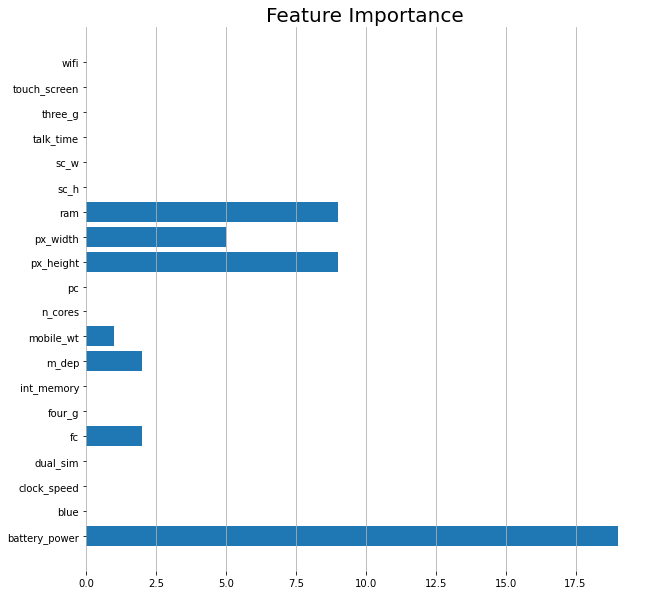

In [112]:
import matplotlib.pyplot as plt

attributes = [0] * len(x_train.values.tolist()[0])
features = clf_depth10.count_feature(attributes, clf_depth10.root, x_train.values.tolist())
names = list(x_train.columns)

fig, x = plt.subplots(figsize =(10, 10))
x.barh(names, features)
for s in ['top', 'bottom', 'left', 'right']: x.spines[s].set_visible(False)
font = {'size':20}
x.set_title("Feature Importance", fontdict=font)
x.grid(axis = 'x')
plt.show()

## Question 4
Implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBoost.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [10]:
class AdaBoost():
    # initialize the Adaboost 
    def __init__(self, n_estimators, max_depth=1):
        # store n_estimators for future usage
        self.n_estimators = n_estimators
        # initialize decision trees (the specified amount)
        self.trees = [DecisionTree(max_depth)] * n_estimators
        # create an array of all alpha value
        self.alpha = []

    # compute error for the certain weak classifier
    def compute_classifier_error(self, tree, x_data, y_data):
        sample_index = np.random.choice(len(x_data), len(x_data), replace=True, p=self.w)
        sample_index = sample_index.tolist()
        boostrap_x = [x_data[i] for i in sample_index]
        boostrap_y = [y_data[i] for i in sample_index]
        tree.fit(boostrap_x, boostrap_y)
        y_pred = tree.predict(x_data)
        error = 0
        for i in range(len(x_data)):
            if y_data[i] != y_pred[i]: error += self.w[i]
        return error

    # compute weight for the weak classifier
    def compute_alpha(self, error):
        return np.log((1 - error) / error) / 2

    # update data weight according to previous weights and alpha
    def update_weight(self, alpha, y_data, y_pred):
        flag = []
        y_pred = list(y_pred)
        for i in range(len(y_data)):
            if y_data[i] != y_pred[i]: flag.append(-1)
            else: flag.append(1)
        flag = np.array(flag)
        return self.w * np.exp(-alpha * flag) / sum(self.w)

    # train the Adaboost model
    def fit(self, x_data, y_data):
        if isinstance(x_data, pd.DataFrame):
            x_data = x_data.values.tolist()
            y_data = y_data.values.tolist()
        # initialize uniform weight to each instance
        self.w = np.ones(len(x_data)) * 1 / len(x_data)
        for i in range(self.n_estimators):
            # compute classifier error
            clf_error = self.compute_classifier_error(self.trees[i], x_data, y_data)
            # weight classifier -> compute alpha
            self.alpha.append(self.compute_alpha(clf_error))
            # update weight distribution
            y_pred = self.trees[i].predict(x_data)
            self.update_weight(self.alpha[i], y_data, y_pred)

    # make predictions according to the weak classifiers and their weight (alpha)
    def predict(self, x_data):
        if isinstance(x_data, pd.DataFrame): x_data = x_data.values.tolist()
        y_pred = []
        for i in range(len(x_data)):
            t_pred = 0
            for j in range(len(self.trees)):
                prediction = self.trees[j].predict_instance(self.trees[j].root, x_data[i])
                if prediction == 0: t_pred -= self.alpha[j]
                else: t_pred += self.alpha[j]
            if t_pred < 0: y_pred.append(0)
            else: y_pred.append(1)
        y_pred = np.array(y_pred)
        return y_pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [144]:
# train the Adaboost model
ada10 = AdaBoost(10)
ada10.fit(x_train, y_train)
# calculate the accuracy score
print("n_estimators=10 accuracy: ", accuracy_score(y_val.values.tolist(), ada10.predict(x_val)))

# train the Adaboost model
ada100 = AdaBoost(100)
ada100.fit(x_train, y_train)
# calculate the accuracy score
print("n_estimators=100 accuracy: ", accuracy_score(y_val.values.tolist(), ada100.predict(x_val)))

n_estimators=10 accuracy:  0.92
n_estimators=100 accuracy:  0.94


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [11]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        # store variables for future usage
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        # initialize the decision trees (the specified amount)
        self.trees = [DecisionTree(max_depth=max_depth)] * n_estimators

    # boostrap sampling 
    def boostrap_sample(self, x_data, y_data):
        sample_index = np.random.choice(len(x_data), len(x_data), replace=True)
        sample_index = sample_index.tolist()
        boostrap_x = [x_data[x] for x in sample_index]
        boostrap_y = [y_data[x] for x in sample_index]
        return boostrap_x, boostrap_y

    # train the random forest model
    def fit(self, x_data, y_data):
        if isinstance(x_data, pd.DataFrame):
            x_data = x_data.values.tolist()
            y_data = y_data.values.tolist()
        # build different weak classifiers with random sampled data and features
        for i in range(self.n_estimators):
            if self.boostrap == True:
                # random sample data
                x, y = self.boostrap_sample(x_data, y_data)
            else: x, y = x_data, y_data
            self.trees[i].fit(x, y, random_forest=True, max_features=self.max_features)

    # make predictions according to the votes from each weak classifier
    def predict(self, x_data):
        if isinstance(x_data, pd.DataFrame): x_data = x_data.values.tolist()
        y_pred = []
        for i in range(len(x_data)):
            t_pred = [] # the list to store votes
            for j in range(len(self.trees)):
                prediction = self.trees[j].predict_instance(self.trees[j].root, x_data[i])
                t_pred.append(prediction)
            # pick out the majority to be the final prediction
            majority = max(t_pred, key=t_pred.count)
            y_pred.append(majority)
        y_pred = np.array(y_pred)
        return y_pred

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [146]:
# initialize the random forest model
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [147]:
# train the model and calculate accuracy score
clf_10tree.fit(x_train, y_train)
print("clf_10tree accuracy: ", accuracy_score(y_val.values.tolist(), clf_10tree.predict(x_val)))
# train the model and calculate accuracy score
clf_100tree.fit(x_train, y_train)
print("clf_100tree accuracy: ", accuracy_score(y_val.values.tolist(), clf_100tree.predict(x_val)))

clf_10tree accuracy:  0.8433333333333334
clf_100tree accuracy:  0.8466666666666667


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [118]:
# initialize the random forest model
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [148]:
# train the model and calculate accuracy score
clf_random_features.fit(x_train, y_train)
print("clf_random_features accuracy: ", accuracy_score(y_val.values.tolist(), clf_random_features.predict(x_val)))
# train the model and calculate accuracy score
clf_all_features.fit(x_train, y_train)
print("clf_all_features accuracy: ", accuracy_score(y_val.values.tolist(), clf_all_features.predict(x_val)))

clf_random_features accuracy:  0.84
clf_all_features accuracy:  0.94


### Question 6. Train and tune your model on a real-world dataset
Try your best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [12]:
def train_your_model(data):
    ## Define your model and training
    if isinstance(data, pd.DataFrame): data = data.values.tolist()
    x_data = [row[0:-1] for row in data]
    y_data = [row[-1] for row in data]
    my_model = AdaBoost(100)
    my_model.fit(x_train, y_train)
    return my_model

In [13]:
train_dataset = pd.concat([train_df, val_df])
my_model = train_your_model(train_dataset)

In [161]:
x_test = pd.read_csv('x_test.csv')
y_pred = my_model.predict(x_test)

In [ ]:
import pickle
with open('model.pickle', 'wb') as pkl_file:
    pickle.dump(my_model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

np.save("y_pred.npy", y_pred)

In [162]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [123]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [163]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
